In [1]:
# !pip install -q torchtext==0.18.0
# !pip install -q transformers  diffusers  pandas numpy
# !pip install -Uq datasets huggingface_hub fsspec

In [2]:
# from google.colab import drive
# from google.colab import userdata
# from huggingface_hub import login
import os
import re
import collections
import datetime
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from sklearn.metrics import confusion_matrix, classification_report
import datasets
import tqdm
import gradio as gr
import transformers

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.empty_cache()

In [4]:
# #credintials
# hf_token = userdata.get('HF_TOKEN')
# login(hf_token, add_to_git_credential=True)
# drive.mount('/content/drive')

In [5]:
#hyper_parameters
seed = 42
embedding_dim = 80
batch_size = 8
n_epochs = 15
model_name = "bert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
classes = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

Using device: cuda


In [6]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(seed)

In [7]:
def load_and_prepare_data(seed=seed):
    train_data, test_data = datasets.load_dataset("dair-ai/emotion", split=["train", "test"])
    train_validation = train_data.train_test_split(test_size=0.25, seed=seed)
    train_data = train_validation['train']
    validation_data = train_validation['test']
    return train_data, validation_data, test_data

train_data, validation_data, test_data = load_and_prepare_data()

In [8]:
#tokenization
def tokenize_data(train_data, validation_data, test_data,autotokenizer):

  def _tokenize(batch):
    return autotokenizer(batch["text"], padding="max_length", truncation=True, max_length=embedding_dim)

  train_data_numericalized = train_data.map(_tokenize, batched=True, batch_size=len(train_data))
  validation_data_numericalized = validation_data.map(_tokenize, batched=True, batch_size=len(validation_data))
  test_data_numericalized = test_data.map(_tokenize, batched=True, batch_size=len(test_data))

  for ds in [train_data_numericalized, validation_data_numericalized, test_data_numericalized]:
    ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

  return train_data_numericalized, validation_data_numericalized, test_data_numericalized

autotokenizer = AutoTokenizer.from_pretrained(model_name)
train_data_numericalized, validation_data_numericalized, test_data_numericalized = tokenize_data(train_data, validation_data, test_data, autotokenizer)

Map: 100%|██████████| 4000/4000 [00:00<00:00, 8352.15 examples/s]


In [9]:
def create_data_loaders(train_data_numericalized, validation_data_numericalized, test_data_numericalized, batch_size):
    train_data_loader = DataLoader(train_data_numericalized, batch_size, shuffle=True)
    valid_data_loader = DataLoader(validation_data_numericalized, batch_size, shuffle=True)
    test_data_loader = DataLoader(test_data_numericalized, batch_size, shuffle=True)
    return train_data_loader, valid_data_loader, test_data_loader

train_data_loader, valid_data_loader, test_data_loader = create_data_loaders(
    train_data_numericalized, validation_data_numericalized, test_data_numericalized, batch_size
)

In [10]:
def count_parameters(my_model):
    return sum(p.numel() for p in my_model.parameters() if p.requires_grad)

In [11]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [12]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses, epoch_accs = [], []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["input_ids"].to(device)
        att = batch["attention_mask"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids, att)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [13]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses, epoch_accs = [], []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["input_ids"].to(device)
            att = batch["attention_mask"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids, att)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [14]:
def print_classification_summary(prediction, label, class_dict):
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    true_labels = label.cpu().numpy()
    target_names = [class_dict[i] for i in range(len(class_dict))]
    report = classification_report(true_labels, predicted_classes, target_names=target_names, digits=3)
    print("\nClassification Summary:\n")
    print(report)

In [15]:
def predict_sentiment(text, model, tokenizer, device, embedding_dim, classes):
    obj = tokenizer(text, padding="max_length", truncation=True, max_length=embedding_dim)
    ids = obj['input_ids']
    atts = obj['attention_mask']
    tensor_id = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    tensor_att = torch.LongTensor(atts).unsqueeze(dim=0).to(device)
    prediction = model(tensor_id, tensor_att).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return classes[predicted_class], predicted_probability

In [16]:
def plot_metrics(metrics, n_epochs):
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    ax[0].plot(metrics["train_losses"], label="train loss")
    ax[0].plot(metrics["valid_losses"], label="valid loss")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].set_xticks(range(n_epochs))
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(metrics["train_accs"], label="train accuracy")
    ax[1].plot(metrics["valid_accs"], label="valid accuracy")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")
    ax[1].set_xticks(range(n_epochs))
    ax[1].legend()
    ax[1].grid()
    plt.show()

In [17]:
def training_loops(metrics,best_valid_loss, my_model, n_epochs = n_epochs, saving = False):
  for epoch in range(n_epochs):
      train_loss, train_acc = train(
          train_data_loader, my_model, criterion, optimizer, device
      )
      valid_loss, valid_acc = evaluate(valid_data_loader, my_model, criterion, device)
      metrics["train_losses"].append(train_loss)
      metrics["train_accs"].append(train_acc)
      metrics["valid_losses"].append(valid_loss)
      metrics["valid_accs"].append(valid_acc)
      if valid_loss < best_valid_loss and saving == True:
          best_valid_loss = valid_loss
          id = datetime.datetime.now().strftime("%d_%b_%Y_%H_%M_%S")
          torch.save(my_model.state_dict(), "Transformer_fcn_"+id+".pt")
      print(f"epoch: {epoch}")
      print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
      print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")
  return metrics


In [ ]:
class Transformer_fcn(nn.Module):
    def __init__(self,transformer,output_dim, freeze_transformer=False):
        super().__init__()
        hiden_dim = transformer.config.hidden_size
        self.transformer = transformer
        self.fcf = nn.Linear(hiden_dim, output_dim)
        if freeze_transformer:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids, atts):
        transformer_output = self.transformer(input_ids=ids,
            attention_mask=atts,
            output_attentions=False,
            output_hidden_states=True
        )
        # Extract the last hidden state
        last_hidden_state = transformer_output.last_hidden_state
        # Extract the attention weights 
        # attention_weights = transformer_output.attentions
        # Extract the CLS token hidden state
        cls_hidden_state = last_hidden_state[:, 0, :]
        # Use the CLS token hidden state for prediction
        prediction = self.fcf(torch.tanh(cls_hidden_state))
        return prediction

In [19]:
import logging
logging.basicConfig(level=logging.INFO)

transformer = transformers.AutoModel.from_pretrained(model_name)


In [20]:
#hyper_parameters
n_epochs = 3

In [21]:
#model instantiation
best_valid_loss = float("inf")
metrics = collections.defaultdict(list)
my_model = Transformer_fcn(
    transformer=transformer,
    output_dim=len(train_data.unique("label")),
    freeze_transformer=True
).to(device)
print(my_model)
print(f"The model has {count_parameters(my_model):,} trainable parameters")
optimizer = optim.Adam(my_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Transformer_fcn(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [22]:
#calling training loop
metrics = training_loops(metrics,best_valid_loss, my_model, n_epochs, False)

evaluating...: 100%|██████████| 500/500 [00:23<00:00, 21.42it/s]


epoch: 0
train_loss: 1.338, train_acc: 0.498
valid_loss: 1.257, valid_acc: 0.530


evaluating...: 100%|██████████| 500/500 [00:22<00:00, 21.79it/s]


epoch: 1
train_loss: 1.237, train_acc: 0.535
valid_loss: 1.195, valid_acc: 0.564


evaluating...: 100%|██████████| 500/500 [00:23<00:00, 21.29it/s]

epoch: 2
train_loss: 1.200, train_acc: 0.552
valid_loss: 1.169, valid_acc: 0.570


In [23]:
#addtional_training
Addition_epochs=10
metrics = training_loops(metrics,best_valid_loss, my_model, Addition_epochs, True)
n_epochs += Addition_epochs

evaluating...: 100%|██████████| 500/500 [00:23<00:00, 21.41it/s]


epoch: 0
train_loss: 1.180, train_acc: 0.557
valid_loss: 1.174, valid_acc: 0.569


evaluating...: 100%|██████████| 500/500 [00:23<00:00, 21.30it/s]


epoch: 1
train_loss: 1.169, train_acc: 0.562
valid_loss: 1.160, valid_acc: 0.573


evaluating...: 100%|██████████| 500/500 [00:23<00:00, 21.26it/s]


epoch: 2
train_loss: 1.166, train_acc: 0.561
valid_loss: 1.165, valid_acc: 0.573


evaluating...: 100%|██████████| 500/500 [00:23<00:00, 21.41it/s]


epoch: 3
train_loss: 1.159, train_acc: 0.561
valid_loss: 1.154, valid_acc: 0.577


evaluating...: 100%|██████████| 500/500 [00:23<00:00, 21.28it/s]


epoch: 4
train_loss: 1.154, train_acc: 0.565
valid_loss: 1.154, valid_acc: 0.570


evaluating...: 100%|██████████| 500/500 [00:23<00:00, 21.21it/s]


epoch: 5
train_loss: 1.148, train_acc: 0.567
valid_loss: 1.143, valid_acc: 0.579


evaluating...: 100%|██████████| 500/500 [00:23<00:00, 21.30it/s]


epoch: 6
train_loss: 1.147, train_acc: 0.569
valid_loss: 1.147, valid_acc: 0.586


evaluating...: 100%|██████████| 500/500 [00:23<00:00, 21.62it/s]


epoch: 7
train_loss: 1.148, train_acc: 0.569
valid_loss: 1.140, valid_acc: 0.573


evaluating...: 100%|██████████| 500/500 [00:23<00:00, 21.50it/s]


epoch: 8
train_loss: 1.139, train_acc: 0.578
valid_loss: 1.147, valid_acc: 0.578


evaluating...: 100%|██████████| 500/500 [00:23<00:00, 21.68it/s]

epoch: 9
train_loss: 1.140, train_acc: 0.570
valid_loss: 1.149, valid_acc: 0.573


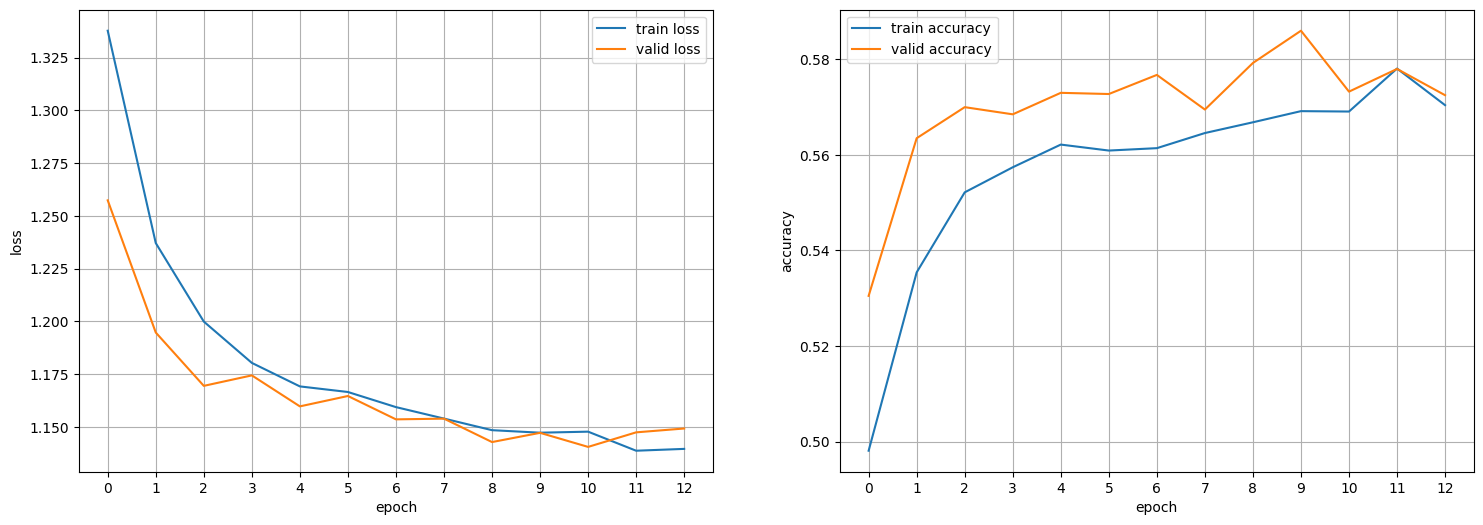

In [24]:
#plot train and validation loss and accuracy
plot_metrics(metrics, n_epochs)

In [25]:
# Test evaluation
test_loss, test_acc = evaluate(test_data_loader, my_model, criterion, device)
print("\ntest_loss", test_loss)
print("test_accuracy", test_acc)


evaluating...: 100%|██████████| 250/250 [00:11<00:00, 21.83it/s]


test_loss 1.1037735127210617
test_accuracy 0.591


In [26]:
# Classification report
with torch.no_grad():
    all_preds, all_labels = [], []
    for batch in tqdm.tqdm(test_data_loader, desc="evaluating..."):
        ids = batch["input_ids"].to(device)
        att = batch["attention_mask"].to(device)
        label = batch["label"].to(device)
        prediction = my_model(ids, att)
        all_preds.append(prediction)
        all_labels.append(label)
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    print_classification_summary(all_preds, all_labels, classes)

evaluating...: 100%|██████████| 250/250 [00:11<00:00, 22.34it/s]


Classification Summary:

              precision    recall  f1-score   support

     sadness      0.566     0.709     0.629       581
         joy      0.696     0.744     0.719       695
        love      0.327     0.308     0.317       159
       anger      0.565     0.378     0.453       275
        fear      0.525     0.371     0.435       224
    surprise      0.459     0.258     0.330        66

    accuracy                          0.591      2000
   macro avg      0.523     0.461     0.481      2000
weighted avg      0.584     0.591     0.580      2000



In [27]:
# Example predictions
example_texts = [
    "iam happy to meet you",
    "i love you",
    "iam very upset iam sick",
    "i cant stand delaying my PhD defense any more",
    "i can punhs them in the face right now",
    "the hardest part about growing up is saying goodby to childhood dreams",
    "how did you do that to me?",
    "how dare you stand where he stod?"
]
for text in example_texts:
    sentiment, prob = predict_sentiment(text, my_model, autotokenizer, device, embedding_dim, classes)
    print(f"Text: {text}\nPredicted: {sentiment} ({prob:.3f})\n")

Text: iam happy to meet you
Predicted: joy (0.722)

Text: i love you
Predicted: love (0.478)

Text: iam very upset iam sick
Predicted: sadness (0.527)

Text: i cant stand delaying my PhD defense any more
Predicted: sadness (0.349)

Text: i can punhs them in the face right now
Predicted: anger (0.333)

Text: the hardest part about growing up is saying goodby to childhood dreams
Predicted: joy (0.640)

Text: how did you do that to me?
Predicted: anger (0.731)

Text: how dare you stand where he stod?
Predicted: anger (0.916)



In [28]:
#save the model using pckl file
import pickle
id = datetime.datetime.now().strftime("%d_%b_%Y_%H_%M_%S")
with open('./models/Transformer_fcn_model_sentiment_'+id+'.pkl', 'wb') as f:
    pickle.dump(my_model, f)

In [29]:
def gradio_predict(text):
      sentiment, prob = predict_sentiment(
          text, my_model, autotokenizer, device, embedding_dim, classes
      )
      return f"{sentiment} ({prob:.2f} confidence)"

# Launch Gradio interface
demo = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Textbox(lines=3, placeholder="Enter a sentence..."),
    outputs=gr.Textbox(label="Predicted Sentiment"),
    title="Sentiment Analysis with NBoW",
    description="Enter a sentence to analyze its sentiment using a custom neural bag-of-words model.",
    examples=[ example_texts[i] for i in range(len(example_texts)) ]
)

# demo.launch()

INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


In [30]:
import winsound

winsound.Beep(1000, 200)
